Deep Learning (Model Bi-LSTM with Word2Vec)
-----------------

* Word2Vec was developed by Google and is one of the most popular technique to learn word embeddings using shallow neural network. Word2Vec can create word embeddings using two methods (both involving Neural Networks): Skip Gram and Common Bag Of Words (CBOW).


* Word2Vec takes texts as training data for a neural network. The resulting embedding captures whether words appear in similar contexts.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import tensorflow as tf
import sklearn
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, MaxPooling1D, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

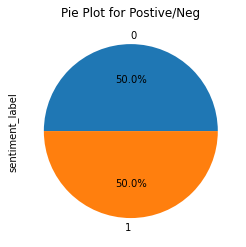

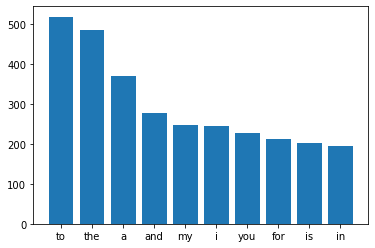

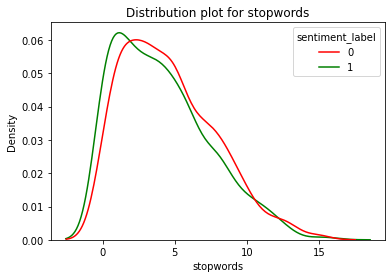

In [ ]:
%run EDA.ipynb

#### Keras Tokenizer

fit_on_texts:  Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_preprocess.tweet)

#Create a dictionary
word_index = tokenizer.word_index

Tokenizer.word_index is a python dictionary that contains token keys (string) and token ID values (integer), and where the first token ID is 1 (not zero) and where the token IDs are assigned incrementally. Therefore, the greatest token ID in word_index is len(word_index). Therefore, we need vocabulary of size len(word_index) + 1 to be able to index up to the greatest token ID.

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_preprocess['tweet'], 
                                                    df_preprocess['sentiment_label'], test_size=0.25, 
                                                    random_state=42)

In [ ]:
# Creating Word2Vec train dataset.
train_data = [x.split() for x in X_train]

In [ ]:
#declare the embedding dimension
EMBEDDING_DIM = 300

#### Create the Word2Vec Embedding

In [ ]:
word2vec_model = Word2Vec(train_data,vector_size=EMBEDDING_DIM, workers=8, min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

In [ ]:
# Define the model input length
max_sequence_length = 20

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_sequence_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=max_sequence_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

In [ ]:
batch_size = 512
epoch = 15

In [ ]:
# Create the embedding layer
embedding_layer = Embedding(vocab_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)

**Reduce Overfitting**

**Early Stopping**

* monitor: The quantity to be monitored.

* min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less   min_delta, will count as no improvement.

* patience: Number of epochs with no improvement after which training will be stopped.

**ReduceLROnPlateau**

ReduceLROnPlateau is a scheduling technique that decreases the learning rate when the specified metric stops improving for longer than the patience number allows. Thus, the learning rate is kept the same as long as it improves the metric quantity, but the learning rate is reduced when the results run into stagnation

* factor: a factor by which the learning rate will be reduced when the quantity stops improving. The formula is the following: new_learning_rate = learning_rate * factor.

* min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less   min_delta, will count as no improvement.

* min_lr: the minimum learning rate for all the parameters. The learning rate would stay at this constant minimum once it reaches it.

* monitor : The quantity to be monitored.

* verbose: verbosity mode, 0 or 1.

In [ ]:
es=EarlyStopping(monitor='val_loss', min_delta=0, mode='min', verbose=1, patience=5)

reduce_lr = ReduceLROnPlateau(factor=0.1, min_delta=0, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

### Create the Bidirectional LSTM Model

In [ ]:
inputs = Input(shape=(max_sequence_length,), dtype="int32")

x = embedding_layer(inputs)
#x = SpatialDropout1D(0.2)(x)

# Bidirectional LSTM 
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)

# Vanilla hidden layer:
x = Dense(128, activation="relu")(x)
x=Dropout(0.2)(x)

outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch,
                    validation_data=(X_test, y_test), callbacks= [es, reduce_lr])

### Plot the learning curves

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('Bi-LSTM with Word2Vec embedding')
plt.xlabel('Epoch')
plt.legend(['Training_accuracy', 'validation_accuracy'], loc='upper left');

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('error')
plt.title('Bi-LSTM with Word2Vec embedding')
plt.xlabel('Epoch')
plt.legend(['Training_loss', 'validation_loss'], loc='lower left');

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))